# Question 3

### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
RANDOM_STATE = 123

### Loading Data

In [2]:
crawled_df = pd.read_csv('Q1_Mudah_PropAds.csv')
crawled_df.head()

,list_title,url,price,area,category,prop_type,prop_title1,prop_title2,bedrooms,bathroom,facilities,size,size_unit
0,New Luxury Freehold Residence 4min Walk to Mid...,https://www.mudah.my/New+Luxury+Freehold+Resid...,597000,Mid Valley City,Apartments,Condo / Services residence / Penthouse / Townh...,Freehold,Non Bumi Lot,1.0,2.0,NaN,689.0,sq.ft.
1,Sri Putramas 1 1100sqft Jalan Kuching Below Ma...,https://www.mudah.my/Sri+Putramas+1+1100sqft+J...,405000,Jalan Kuching,Apartments,Condo / Services residence / Penthouse / Townh...,Freehold,Non Bumi Lot,3.0,2.0,"Swimming Pool, Gymnasium, Tennis Court, Squash...",1100.0,sq.ft.
2,0% DOWNPAYMENT Arena Green 750SF Bukit Jalil [...,https://www.mudah.my/0+DOWNPAYMENT+Arena+Green...,320000,Bukit Jalil,Apartments,Condo / Services residence / Penthouse / Townh...,Freehold,Non Bumi Lot,3.0,2.0,"Mini Market, Playground, Jogging Track, 24 Hou...",878.0,sq.ft.
3,[Duplex Penthouse] Silk Residence Duplex Doubl...,https://www.mudah.my/+Duplex+Penthouse+Silk+Re...,900000,Cheras,Apartments,Condo / Services residence / Penthouse / Townh...,Freehold,Non Bumi Lot,6.0,7.0,"Swimming Pool, Gymnasium, Mini Market, Playgro...",4177.0,sq.ft.
4,BELOW MARKET!! Menara D'Sara Condo Sri Damansa...,https://www.mudah.my/BELOW+MARKET+Menara+D+Sar...,380000,Sri Damansara,Apartments,Condo / Services residence / Penthouse / Townh...,Freehold,Non Bumi Lot,3.0,2.0,"Swimming Pool, Gymnasium, Tennis Court, Squash...",1130.0,sq.ft.


### One Hot Encode Facilities Column

In [3]:
# Convert facilities into one-hot encodings
facilities_list = np.unique([x for row in crawled_df['facilities'].astype(str).unique() for x in row.split(', ') if len(x) > 1])
facilities_list = facilities_list[facilities_list != 'Gymnasium,']
for item in facilities_list:
    crawled_df[item] = (crawled_df['facilities'].astype(str).str.find(item)>= 0)
crawled_df = crawled_df.rename(columns={'nan':'No Facilities'}).drop('facilities', axis=1)

### Feature Selection

,price,bedrooms,bathroom,size,24 Hour Security,Balcony/Patio,Cable TV,Gymnasium,Jogging Track,Mini Market,Playground,Squash Court,Swimming Pool,Tennis Court,No Facilities
price,1.000000,0.577591,0.650346,0.362834,-0.133872,-0.106777,-0.069274,-0.100904,-0.087112,-0.153133,-0.134880,-0.072716,-0.100543,-0.075165,0.147822
bedrooms,0.577591,1.000000,0.801869,0.629412,-0.129402,-0.160680,-0.103236,-0.208460,-0.060593,-0.202835,-0.097517,-0.109416,-0.210006,-0.138629,0.088343
bathroom,0.650346,0.801869,1.000000,0.639401,-0.023064,-0.040415,-0.031102,-0.055564,-0.000576,-0.166174,-0.039891,-0.061494,-0.078905,-0.064787,0.010876
size,0.362834,0.629412,0.639401,1.000000,-0.130083,-0.107004,-0.075188,-0.104601,-0.077939,-0.148390,-0.126027,-0.067526,-0.111359,-0.069076,0.137216
24 Hour Security,-0.133872,-0.129402,-0.023064,-0.130083,1.000000,0.690779,0.463279,0.646027,0.577204,0.580090,0.747265,0.352890,0.715461,0.377434,-0.870900
Balcony/Patio,-0.106777,-0.160680,-0.040415,-0.107004,0.690779,1.000000,0.529548,0.591193,0.545449,0.552973,0.658281,0.430767,0.638514,0.488692,-0.648199
Cable TV,-0.069274,-0.103236,-0.031102,-0.075188,0.463279,0.529548,1.000000,0.461260,0.649363,0.543607,0.508841,0.539506,0.444008,0.540492,-0.470595
Gymnasium,-0.100904,-0.208460,-0.055564,-0.104601,0.646027,0.591193,0.461260,1.000000,0.558140,0.545553,0.595067,0.496363,0.861153,0.535132,-0.571936
Jogging Track,-0.087112,-0.060593,-0.000576,-0.077939,0.577204,0.545449,0.649363,0.558140,1.000000,0.559886,0.660906,0.506873,0.534073,0.535809,-0.549383
Mini Market,-0.153133,-0.202835,-0.166174,-0.148390,0.580090,0.552973,0.543607,0.545553,0.559886,1.000000,0.664739,0.445408,0.553265,0.409217,-0.644952


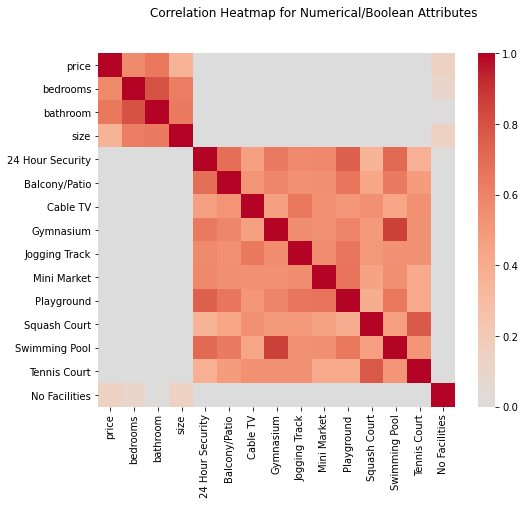

In [4]:
# We use correlation heatmap to look at the numerical and boolean attributes
corr = crawled_df.corr()
display(corr.style.applymap(lambda x: 'background-color: yellow' if x > 0.75 else ''))


# plot the heatmap

fig, ax = plt.subplots(figsize=(8,6.5))    
sns.heatmap(corr, 
            vmin = 0,
            vmax =1,
            cmap = 'coolwarm',
            center=0,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            ax=ax)
plt.suptitle('Correlation Heatmap for Numerical/Boolean Attributes')
plt.show()


__We want to remove features that are highly correlated with each others__
* From those highly correlated pairs, removed one from each pair from the dataframe
<br>1) bedrooms and bathrooms
<br>2) swimming pool and gymnasium
<br>3) tennis court and squash court

In [5]:
crawled_df.drop(['bathroom', 'Gymnasium', 'Squash Court'], axis=1, inplace=True)

In [6]:
crawled_df.iloc[:,3:].columns

Index(['area', 'category', 'prop_type', 'prop_title1', 'prop_title2',
       'bedrooms', 'size', 'size_unit', '24 Hour Security', 'Balcony/Patio',
       'Cable TV', 'Jogging Track', 'Mini Market', 'Playground',
       'Swimming Pool', 'Tennis Court', 'No Facilities'],
      dtype='object')

### Splitting Data
We use a simple train_test_split for this purpose

In [7]:
# One hot remaining categorical items for 
dummies = pd.get_dummies(crawled_df[['area', 'category', 'prop_type', 'prop_title1', 'prop_title2', 'size_unit']])
onehot_df = pd.concat([crawled_df.drop(['area', 'category', 'prop_type', 'prop_title1', 'prop_title2', 'size_unit'], axis=1), dummies], axis=1).fillna(0)

In [8]:
# Define X and y, we want to predict property ads price from the property attributes
X = onehot_df.iloc[:,3:]
y = onehot_df['price']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Building Decision Tree Model

In [10]:
# Prune Tree and leafs, set criterion to 'entropy'
# max_depth = 5, min_samples_leaf=100
model = DecisionTreeRegressor(criterion='mae', max_depth=5, max_features=22, min_samples_split=3, random_state=RANDOM_STATE)

### Evaluating Model

In [11]:

model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
mae_train = mean_absolute_error(y_pred_train, y_train)
print(f'Training data mean absolute error: {mae_train}')


y_pred_test = model.predict(X_test)
mae_test = mean_absolute_error(y_pred_test, y_test)
print(f'Testing data mean absolute error: {mae_test}')


Training data mean absolute error: 251660.1625
Testing data mean absolute error: 436625.0125


### Visualizing Decision Trees

In the tree plot below, the darker colors indicate majority class for classification.

 double click on figure below to zoom in


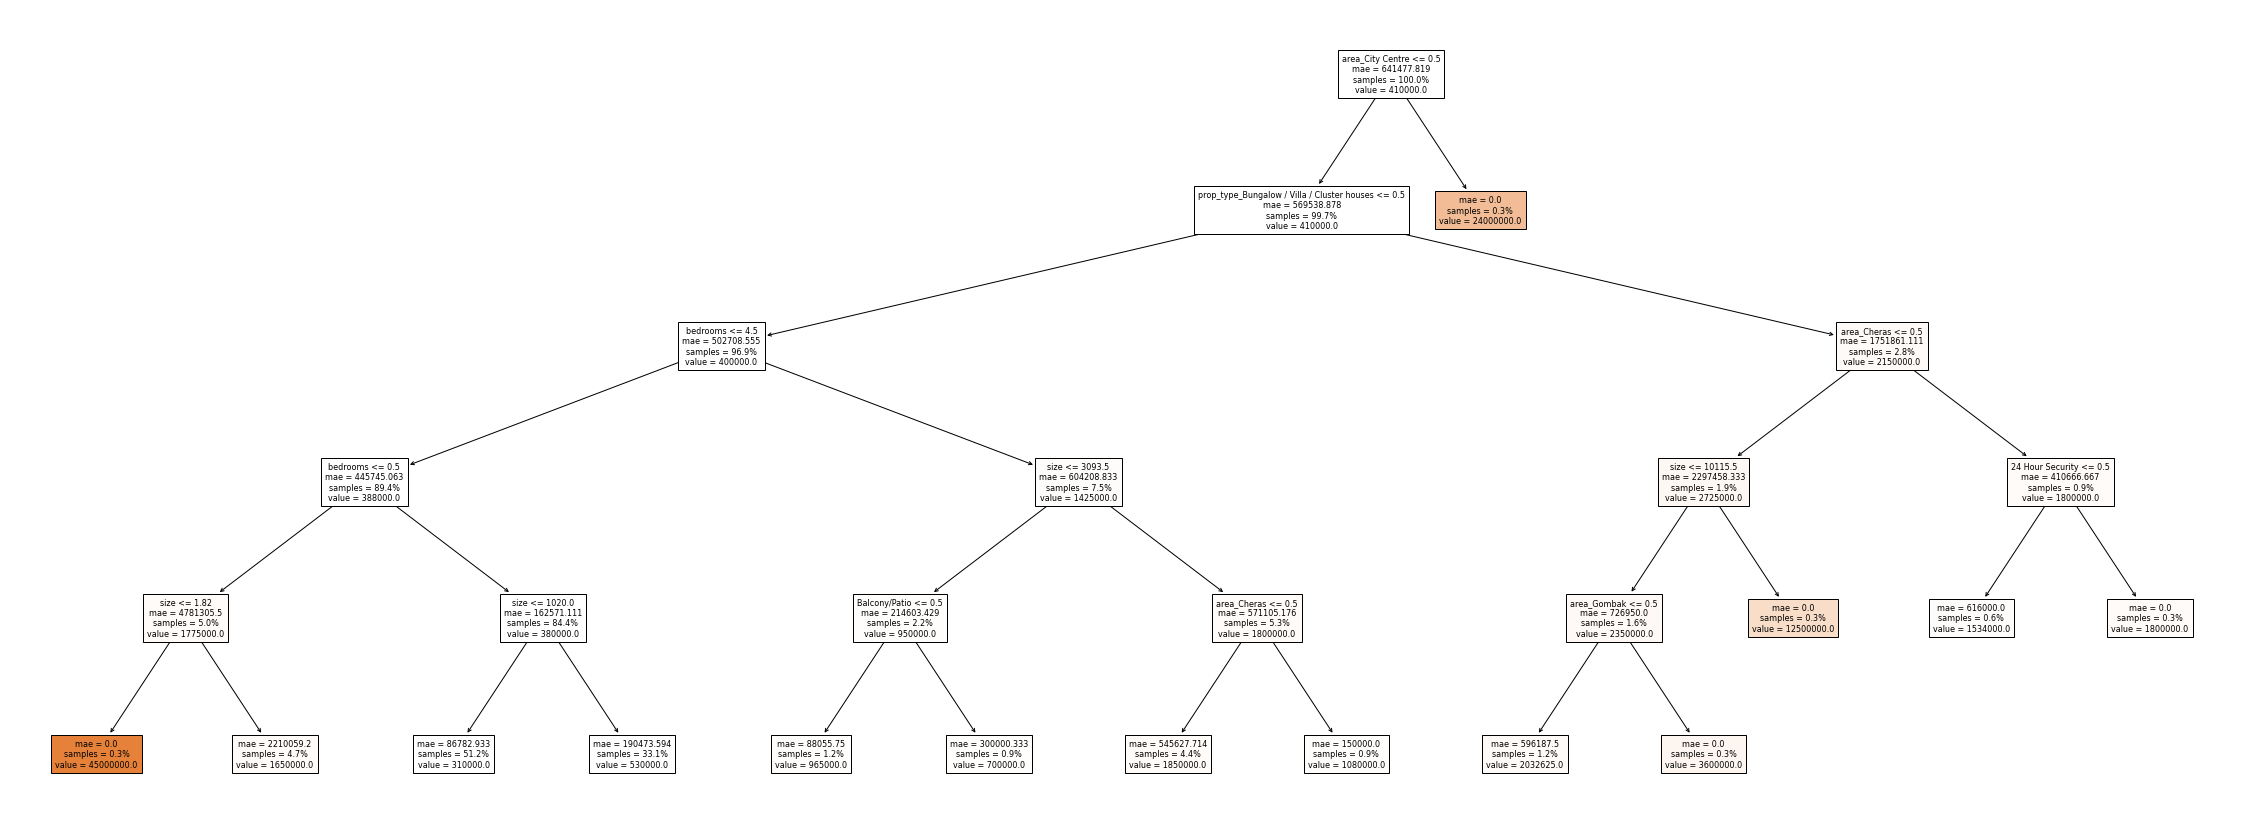

In [15]:
from sklearn import tree
features = X_train.columns
fig, ax = plt.subplots(figsize=(40, 15))
tree.plot_tree(model, feature_names=features, fontsize=8, proportion=True, filled=True)

print('In the tree plot below, the darker colors indicate majority class for classification.')
print('\n double click on figure below to zoom in')

fig.savefig('tree_structure.png')

### Feature Importance

In [13]:
result = permutation_importance(model, X_train, y_train, n_repeats=10,
                                random_state=RANDOM_STATE, n_jobs=6)
sorted_idx = result.importances_mean.argsort()

print(f'Top five most importance features are {list(X_train.columns[sorted_idx[:-5:-1]])}')

Top five most importance features are ['bedrooms', 'size', 'area_City Centre', 'prop_type_Bungalow / Villa / Cluster houses']


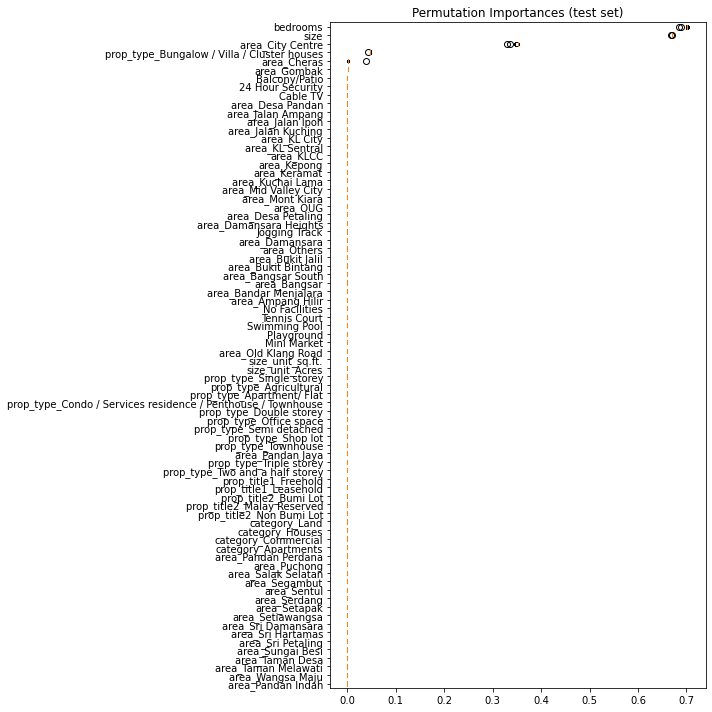

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()